# PPO

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/EVA_MiLab_Hackathon

%load_ext autoreload
%autoreload 2

Mounted at /content/gdrive
/content/gdrive/My Drive/EVA_MiLab_Hackathon


In [2]:
!pip install swig
!pip install "gymnasium[box2d]==1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379445 sha256=dcb66a167edf8f2620deb40c7f927a06b2debd29074b187e74bd1e77c944150c
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
from time import gmtime, strftime
import gymnasium as gym
import numpy as np
import torch
from matplotlib import pyplot as plt
from agents.cnn_ppo import CNN_PPO_Agent

def plot_durations(episode_durations, show_result=False, save_path=None):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')

    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved at {save_path}")


def train_agent(episodes, run_name):
    env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)
    env._max_episode_steps = 1000
    agent = CNN_PPO_Agent(input_shape=(3, 96, 96), run_name=run_name)

    for episode in range(episodes):
        state, info = env.reset()

        state = torch.tensor(state, dtype=torch.float32, device=agent.device)
        state = state.permute(2, 0, 1).unsqueeze(0)  # Ensure shape (1, C, H, W)

        total_reward = 0
        done = False
        t = 0

        while not done:
            action, log_prob, value = agent.select_action(state)
            action = np.array(action, dtype=np.float32)

            next_state, reward, done, _, _ = env.step(action)

            next_state = torch.tensor(next_state, dtype=torch.float32, device=agent.device)
            next_state = next_state.permute(2, 0, 1).unsqueeze(0)  # Ensure shape (1, 3, 96, 96)



            agent.store_transition((state, action, reward, next_state, log_prob, value, done))
            agent.update()

            state = next_state
            total_reward += reward
            t += 1

            # print(f"Step {t}: Reward={reward:.2f}, Done={done}")

            if t >= 1000:  # Force episode termination after 1000 steps
                print(f"Episode {episode} reached max steps (1000), terminating.")
                done = True

            if done:
                agent.episode_durations.append(episode + 1)
                plot_durations(agent.episode_durations)

                if episode == episodes - 1:
                    plot_durations(agent.episode_durations, show_result=True, save_path=f"plots/{run_name}_training_plot.png")
                break

        agent._log_reward(episode, total_reward)

        if episode % 50 == 0:
            agent.save_checkpoint(episode)

        print(f"Episode {episode}: Total Reward: {total_reward}")

    env.close()

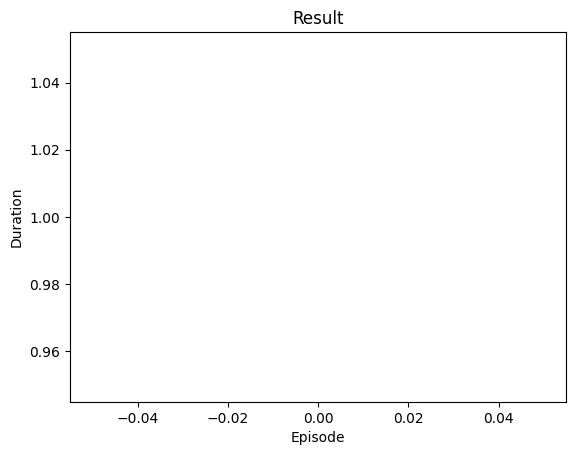

<Figure size 640x480 with 0 Axes>

Plot saved at plots/CNN_PPO_20250211124655_training_plot.png
Checkpoint saved at episode 0
Episode 0: Total Reward: -78.72340425531884


<Figure size 640x480 with 0 Axes>

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")


RUN_NAME = f"CNN_PPO_{strftime('%Y%m%d%H%M%S', gmtime())}"
train_agent(episodes = 1, run_name = RUN_NAME)